In [33]:
import matplotlib.pyplot as plt
from datasets import load_dataset
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import scipy
import math
from nltk.tokenize import word_tokenize
import torch
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from transformers import pipeline
if torch.cuda.is_available():
    device = "cuda"
elif torch.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print("We would be using this device:", device)

We would be using this device: cuda


# Loading and Preprocessing of TL;DR

we have loaded the datasets using the hugging face's datasets library, we have observed the TL-DR Datasets split already done into train, test and validation

In [2]:
data_set = load_dataset("trl-lib/tldr")
ds = data_set

In [3]:
train_set = pd.DataFrame(ds["train"])
print(ds.keys())

dict_keys(['train', 'validation', 'test'])


In [4]:
train_size, validation_size, test_size = ds["train"].shape[0], ds["validation"].shape[0], ds["test"].shape[0]
toto = train_size + validation_size + test_size

print("Training Set Size: ", "{:.2f}".format(train_size / toto * 1e2), "%",  " With Records: ", train_size,sep="")
print("Test Set Size: ", "{:.2f}".format(test_size / toto * 1e2), "%",  " With Records: ", test_size,sep="")
print("Validation Set Size: ", "{:.2f}".format(validation_size / toto * 1e2), "%", " With Records: ", validation_size, sep="")

Training Set Size: 89.98% With Records: 116722
Test Set Size: 5.05% With Records: 6553
Validation Set Size: 4.97% With Records: 6447


In [5]:
record = train_set.sample(random_state=56)

In [6]:
print(record.prompt.values[0])

SUBREDDIT: r/AskReddit

TITLE: Is my school extorting me?

POST: I received a parking ticket last Monday from my school.  I had bought a parking pass for the year for school, and due to circumstances beyond my control, the pass found itself locked in my dads truck 20 minutes from home in the opposite direction of school.  

I took my parents car to school (both vehicles are registered with the school on the parking pass) and received a parking ticket for "failing to show a valid permit.".  I appealed the ticket online through the school's website on Tuesday, and I received back a PDF file on Wednesday morning informing me that my appeal was denied (no explanation).  I then emailed the manager Thursday afternoon explaining the situation and asking for an explanation.  

Fast forward to today (Monday).  I still haven't heard back from the manager and if I don't pay the ticket by tonight, the fee will go from $30 to $45.  I'm strapped for cash, but have no choice but to pay it, because I 

In [7]:
print(record.completion.values[0])

 Parking pass registered for 2 vehicles was left at home.  Appeal was denied, nobody has responded. Fee increases tomorrow.


## Preprocessing Task

We wanted to have post and its title and content seperately so we wanted to extract them out first

1. Extract Title of the Reddit Post
2. Extract Post Content 
3. Extract the Subreddit where this post belongs to

We have decided to keep the text as human written as possible

## Extract Title - using Regex

we would be using Regex for extracting the title out of the Reddit Post

In [8]:
print(record.prompt.str.extract(r'TITLE: ((.|\n)*)\n\nPOST:').values[0][0])

Is my school extorting me?


## Extract Post - using Regex

likewise we would be using the Regex for extracting the Post content out of the Reddit Post

In [9]:
print(record.prompt.str.extract(r'POST: ((.|\n)*)\nTL;DR:', expand=False).values[0][0])

I received a parking ticket last Monday from my school.  I had bought a parking pass for the year for school, and due to circumstances beyond my control, the pass found itself locked in my dads truck 20 minutes from home in the opposite direction of school.  

I took my parents car to school (both vehicles are registered with the school on the parking pass) and received a parking ticket for "failing to show a valid permit.".  I appealed the ticket online through the school's website on Tuesday, and I received back a PDF file on Wednesday morning informing me that my appeal was denied (no explanation).  I then emailed the manager Thursday afternoon explaining the situation and asking for an explanation.  

Fast forward to today (Monday).  I still haven't heard back from the manager and if I don't pay the ticket by tonight, the fee will go from $30 to $45.  I'm strapped for cash, but have no choice but to pay it, because I can't afford to pay the extra $15.  If I don't pay the ticket at 

In [10]:
print(record.prompt.values[0])

SUBREDDIT: r/AskReddit

TITLE: Is my school extorting me?

POST: I received a parking ticket last Monday from my school.  I had bought a parking pass for the year for school, and due to circumstances beyond my control, the pass found itself locked in my dads truck 20 minutes from home in the opposite direction of school.  

I took my parents car to school (both vehicles are registered with the school on the parking pass) and received a parking ticket for "failing to show a valid permit.".  I appealed the ticket online through the school's website on Tuesday, and I received back a PDF file on Wednesday morning informing me that my appeal was denied (no explanation).  I then emailed the manager Thursday afternoon explaining the situation and asking for an explanation.  

Fast forward to today (Monday).  I still haven't heard back from the manager and if I don't pay the ticket by tonight, the fee will go from $30 to $45.  I'm strapped for cash, but have no choice but to pay it, because I 

## Extracting the Title and the Post from the dataset into seperate columns.

Convert the Dataset to Data Frame and then add columns for post and title

In [11]:
ds = {}
for set_type in data_set.keys():
  ds[set_type] = pd.DataFrame(data_set[set_type])
  ds[set_type]["prompt_post"] = ds[set_type].prompt.str.extract(
      r'POST: ((.|\n)*)\nTL;DR:', expand=False
  ).iloc[:, 0]
  ds[set_type]["prompt_title"] = ds[set_type].prompt.str.extract(
    r'TITLE: ((.|\n)*)\n\nPOST:', expand=False
  ).iloc[:, 0]
  ds[set_type]["subreddit"] = ds[set_type].prompt.str.extract(
    r'SUBREDDIT: ((.|\n)*)\n\nTITLE:', expand=False
  ).iloc[:, 0]


In [13]:
train_set = ds["train"]
print(train_set.iloc[0, :])

prompt          SUBREDDIT: r/relationships\n\nTITLE: I (f/22) ...
completion       I still have contact with an old ex's friends...
prompt_post     Not sure if this belongs here but it's worth a...
prompt_title    I (f/22) have to figure out if I want to still...
subreddit                                         r/relationships
Name: 0, dtype: object


# Topics

we wanted to see where the posts are mostly coming from, so we extracted the subreddit from the post

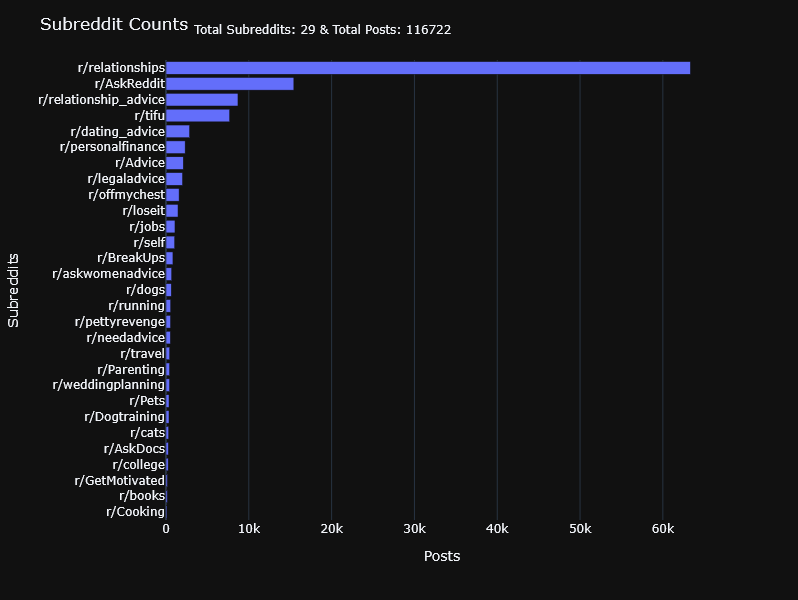

In [15]:
# plot a bargraph of the subreddit counts
subreddit_counts = train_set.subreddit.value_counts().sort_values()

fig = px.bar(subreddit_counts, y=subreddit_counts.index, x=subreddit_counts.values)
fig.update_layout(
    # text box displaying the total subreddits and the total counts
    title_text=f'Subreddit Counts <sub>Total Subreddits: {len(subreddit_counts)} & Total Posts: {subreddit_counts.sum()}</sub>',
    yaxis_title='Subreddits',
    xaxis_title='Posts',
    template='plotly_dark', height=600
)
fig.show()

# Do some basic statistics on the Train set

* Extract the Number of Words in the Prompt
* Extract the Number of Words in the Completion Text
* Extract the Number of Words in the Title


and see if there's any pattern between them

In [16]:
n_words_prompt = []
n_words_completion = []
n_words_title = []
for prompt, completion, title in zip(train_set.prompt, train_set.completion, train_set.prompt_title):
  n_words_prompt.append(len(word_tokenize(prompt)))
  n_words_completion.append(len(word_tokenize(completion)))
  n_words_title.append(len(word_tokenize(title)))

counts = pd.DataFrame(
    {
        "prompt": n_words_prompt,
        "completion": n_words_completion,
        "title": n_words_title,
    }
)


In [28]:
for (task, _counts) in ((
    ("Prompt", n_words_prompt),
    ("Prompt's Completion", n_words_completion),
    ("Prompt's Title", n_words_title),
)):
    stats = scipy.stats.describe(_counts)
    print("Stats for the", task, ":", stats)
    print("STD:", math.sqrt(stats.variance))
    print()

Stats for the Prompt : DescribeResult(nobs=np.int64(116722), minmax=(np.int64(17), np.int64(784)), mean=np.float64(313.13578417093606), variance=np.float64(7947.000376596112), skewness=np.float64(-0.0821211041678182), kurtosis=np.float64(-0.8761590153986032))
STD: 89.14594986086644

Stats for the Prompt's Completion : DescribeResult(nobs=np.int64(116722), minmax=(np.int64(7), np.int64(54)), mean=np.float64(30.916005551652646), variance=np.float64(41.55023105035428), skewness=np.float64(0.4995597237178261), kurtosis=np.float64(-0.5853240074797359))
STD: 6.445946869960555

Stats for the Prompt's Title : DescribeResult(nobs=np.int64(116722), minmax=(np.int64(1), np.int64(80)), mean=np.float64(20.187531056698823), variance=np.float64(96.45991837544159), skewness=np.float64(0.667756403683407), kurtosis=np.float64(0.78323210977566))
STD: 9.82140103933454



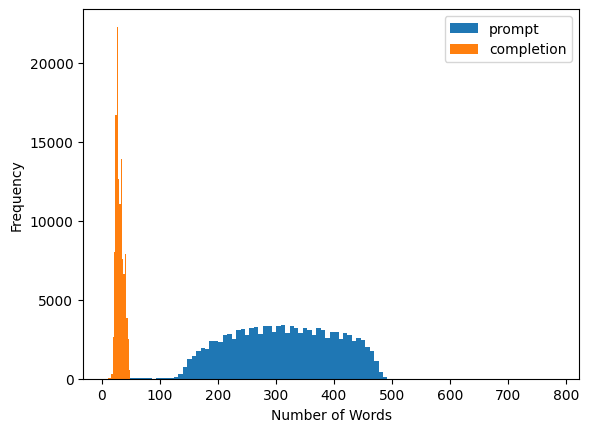

In [29]:
plt.hist(n_words_prompt, bins=100, label="prompt")
plt.hist(n_words_completion, bins = 20, label = "completion")
plt.ylabel("Frequency")
plt.xlabel("Number of Words")
plt.legend()
plt.show()

## Scatter Matrix between prompt, completion and title

Text(0.5, 0.98, 'Pairwise Comparison of Word Counts')

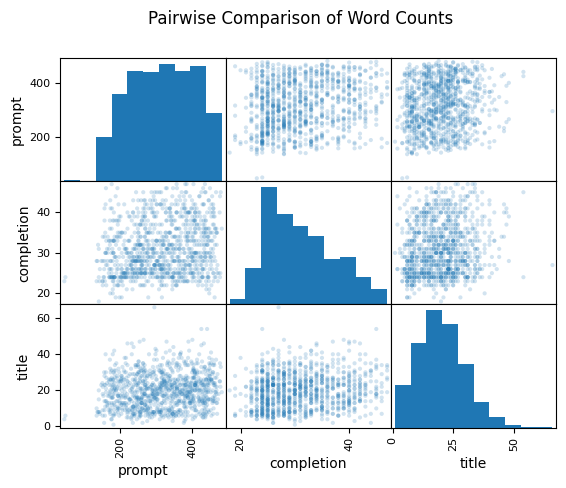

In [30]:
_ = pd.plotting.scatter_matrix(counts.sample(1000), alpha=0.2)
plt.suptitle("Pairwise Comparison of Word Counts")

In [31]:
# correlation?
print(scipy.stats.linregress(n_words_prompt, n_words_completion))
print()
print(scipy.stats.linregress(n_words_prompt, n_words_title))
print()
print(scipy.stats.linregress(n_words_title, n_words_completion))

LinregressResult(slope=np.float64(0.009057317583880375), intercept=np.float64(28.079835307539057), rvalue=np.float64(0.125260601040524), pvalue=np.float64(0.0), stderr=np.float64(0.0002099802100587645), intercept_stderr=np.float64(0.06836491023812478))

LinregressResult(slope=np.float64(0.013091432383661644), intercept=np.float64(16.08813511132015), rvalue=np.float64(0.11882705636464869), pvalue=np.float64(0.0), stderr=np.float64(0.00032019256690338737), intercept_stderr=np.float64(0.10424761499733132))

LinregressResult(slope=np.float64(0.0658685730822965), intercept=np.float64(29.586281686893347), rvalue=np.float64(0.10036099973841521), pvalue=np.float64(6.089289259242715e-259), stderr=np.float64(0.0019113594532263738), intercept_stderr=np.float64(0.04290972182993994))


## Conclusions till now

Any of the Pairs are not co-related, No of Words in the Post, TL;DR and the Title of the Reddit Post

# Understanding more with Evalution Score

We will now be using the Evalution Metrics (Rouge-1 and Rouge-L) to understand more about the TL;DR and the Post based on the results, we are not using it for evalation.

In [45]:
from rouge_score import rouge_scorer
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import torch

In [46]:
train_set_samples = train_set.sample(1000)
train_set_samples.columns, train_set_samples.shape

(Index(['prompt', 'completion', 'prompt_post', 'prompt_title', 'subreddit'], dtype='object'),
 (1000, 5))

In [47]:
record = train_set_samples.sample(random_state=56)
print(record.prompt.values[0])
print("-------------------------------")
print(record.completion.values[0])

SUBREDDIT: r/tifu

TITLE: TIFU By playing Xbox while I had a girl over.

POST: So this happened last night and it was more of the girls FU then mine but...
There is this girl called S I see every once is a while. We used to date but that ended when she posted something about us on Twitter and her parents found out (she isn't allowed to date). That was nearly a year ago and she comes over to "hang out" and after a little while I decide to play Arkham Knight to show her the story and the dynamic between the Joker and Harley Quinn. She is getting into it and decides to start snap chatting people. I contine on with the game and I notice she is taking a video of me. I told her to don't send that to anyone or post it on her snap story but she did anyways. Soon I pause the game and we start having some fun, then her phone rings. Her mom has been calling her (she had 7 missed calls) and she found out that S was with me and wanted her home now. The mom found out because S has her a member of he

In [48]:
scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
scorer.score(record.prompt.values[0], record.completion.values[0])

{'rouge1': Score(precision=0.7777777777777778, recall=0.07553956834532374, fmeasure=0.1377049180327869),
 'rougeL': Score(precision=0.7037037037037037, recall=0.0683453237410072, fmeasure=0.12459016393442625)}

In [ ]:
def rouge_score(p, c):
    scores = scorer.score(p, c)
    return pd.Series({
        'rouge1_precision': scores['rouge1'].precision,
        'rougeL_precision': scores['rougeL'].precision,
    })

scores_df = train_set_samples[["prompt", "completion"]].apply(
    lambda x: rouge_score(x.iloc[0], x.iloc[1]),
    axis=1
)

## ROUGE-1 Precision Score
---
We are using ROUGE-1 Precision Score to understand the overlap of words between the TL;DR and the Reddit Post

it measures unigram overlap between a Reddit Post and the TL;DR w.r.t to the TL;DR of the Post

$$
\text{Rouge1 - Precision} = \frac{\text{Overlapping Unigrams b/w Post and TL;DR}}{\text{Total Unigrams in TL;DR}}
$$


In [ ]:
fig = px.violin(x=scores_df["rouge1_precision"], points="all", box=True, color_discrete_sequence=["orangered"])
fig.update_layout(
    barmode='overlay',
    title='Overlap of Unigrams of Post',
    xaxis_title='Score',
    template='plotly_dark'
)

## Conclusion based on the Rouge Unigram Score's Precision
---
We can see most of the words in the tl;dr are also present in the prompt.That is the TL;DR is mostly referring from the prompt, but includes some words which were not from the prompt.

**so Next question are they directly extracting the words in same order ?**

## ROUGE-L Precision Score
---
We are planning to use this score to see the common and longest LCS in the TL;DR and Post.

ROUGE-L measures the longest common subsequence (LCS) between a prompt and the TL;DR.

$$
\text{Precision} = \frac{\text{Length of LCS}(X, Y)}{\text{Length of TL;DR string}}
$$


### LCS:
---
Here, $\text{LCS}(X, Y)$ is the length of the longest common subsequence between the reference $X$ and the candidate $Y$.

**Sentence 1:** "The quick brown fox jumps over the lazy dog"  
**Sentence 2:** "The slow red cat jumps over the lazy bear"  

__LCS:__ The jumps over the lazy

so Precision of LCS(1, 2) = 5/9


In [ ]:
fig = px.violin(x=scores_df["rougeL_precision"], points="all", box=True, color_discrete_sequence=["orangered"])
fig.update_layout(
    barmode='overlay',
    title='Score for Longest Common SubSequence in the TL;DR and Post',
    xaxis_title='Score',
    template='plotly_dark'
)

fig.show()

## Conclusion based on the RougeL_Precision
---

though the TL;DR seems to have most of the words coming from the prompt but it does not seem to be copying specific part of the sequence of the prompt only (which is expected from good sumarizer) so it is generating TL;DR of the post though it uses most of the words from the prompt but the ordering and paraphrasing is not copied exactly.

## Sentiment Analysis

In [34]:
train_set_sample = train_set_samples.copy()
train_set_sample["post_sentiment"] = train_set_sample.prompt_post.apply(lambda x: SentimentIntensityAnalyzer().polarity_scores(x)["compound"])
train_set_sample["completion_sentiment"] = train_set_sample.completion.apply(lambda x: SentimentIntensityAnalyzer().polarity_scores(x)["compound"])

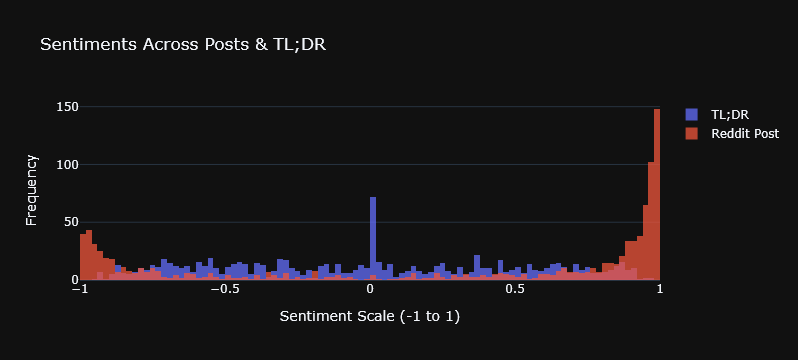

In [44]:
fig = go.Figure()
fig.add_trace(go.Histogram(name="TL;DR", x=train_set_sample["completion_sentiment"], nbinsx=100))
fig.add_trace(go.Histogram(name="Reddit Post", x=train_set_sample["post_sentiment"], nbinsx=100))
fig.update_layout(barmode='overlay')
fig.update_traces(opacity=0.75)
fig.update_layout(
    title='Sentiments Across Posts & TL;DR',
    xaxis_title='Sentiment Scale (-1 to 1)',
    yaxis_title='Frequency',
    template='plotly_dark'
)
fig.show()

# Conclusion and discussion
The analysis we did tells us that the TLDR is very diverse in terms of post, title and TLDR length, and that any permutation of pairs between these variables do not correlate. Eg. meaning that we cannot expect a long TLDR just because the post was long or vice versa. Although it is easy to see from the histogram that the distributions of the number of words in respectively the post's and the , are very different.

The bar graph showing the subreddits tells us that more than half the posts are comming from the subreddit r/relationships. This is useful to know for training the future model as, this could be a bias that we should potentially filter out. This is important as it potentially could eg. bias the model towards being more emotional as one might expect the content in r/relationships to be more emotional.

The sentiment analysis shows that the completions have quite varied sentiment but most are neutral where as the posts are mostly polarizing. This makes sense as you dont have time to explain what you feel in a TL;DR. What we can take from this is that this might be a somewhat good thing for model traning as we want the output to be somewhat neutral and withouth sentiment, so the traning data should also reflect this.

Furthermore from the Rouge 1 score, we can conclude that the words in the TL;DR has around 80% of its words represented in the POST. Which points towards a somewhat diverse use of words in the TL;DRs, not just copying things from the main post. Just for good measure, we know that it is a model evaluation metric, but using it this way on our dataset we have chosen to use it as an analysis measure as we saw it fit. The Rouge L shows that the longest sequences (with or without some other words in between) from the TLDR are on average about 50% represented in the post also pointing towards the TL;DR being more than just a copy of a section in the post.

We left out some different types of analysis like NER. This is because the data set is from reddit and since we have 29 different subreddits represented, we expect the content to be somewhat diverse in terms of sentiment and topics. And the subreddit distribution plot already displays the kind of topics we expect to see.